In [1]:
%load_ext watermark

import numpy as np
import xarray as xr
import pandas as pd
import xcdat as xc

import scipy.stats as stats

import matplotlib as mpl
import matplotlib.pyplot as plt

import cmocean.cm as cmo

%watermark -iv

xcdat     : 0.6.0
sys       : 3.11.6 | packaged by conda-forge | (main, Oct  3 2023, 10:40:35) [GCC 12.3.0]
numpy     : 1.24.4
pandas    : 2.2.0
cmocean   : 3.0.3
scipy     : 1.11.3
matplotlib: 3.8.0
xarray    : 2023.10.1



In [2]:
def calculate_annual_timeseries(da):
    """
    Calculates the annual timeseries, weighted by the number of days in each month
    """
    nyears = len(da.groupby('time.year'))
    month_length = da.time.dt.days_in_month

    weights = month_length.groupby('time.year') / month_length.astype(float).groupby('time.year').sum()        
    np.testing.assert_allclose(weights.groupby('time.year').sum().values, np.ones(nyears)) 

    return (da * weights).groupby('time.year').sum(dim='time')

def format_ds_coords(ds):
    ds = ds.bounds.add_bounds('X')
    ds = ds.bounds.add_bounds('Y')
    ds = xc.swap_lon_axis(ds, (-180, 180))
    return ds

# LAI screening

In [3]:
lai = xc.open_dataset('/glade/work/bbuchovecky/WUE_analysis/clm50_cesm23a02cPPEn08ctsm51d030_1deg_GSWP3V1_hist.clm2.h1.TLAI.185001-201412_gridded.nc')
lai = format_ds_coords(lai)
lai = lai['TLAI']

gpp = xc.open_dataset('/glade/work/bbuchovecky/WUE_analysis/clm50_cesm23a02cPPEn08ctsm51d030_1deg_GSWP3V1_hist.clm2.h1.GPP.185001-201412_gridded.nc')
gpp = format_ds_coords(gpp)
gpp = gpp['GPP']

gpp_full_linregress = xr.open_dataset('/glade/work/bbuchovecky/WUE_analysis/trends/GPP_linregress.190101-201412.nc')['GPP']

In [4]:
gpp_full_linregress.sel(site=0, vegtype=1).stats_descr.values

array(['slope [X/10yr]', 'rvalue', 'pvalue'], dtype=object)

Text(0.5, 1.0, 'GPP ; [-71.250,-39.110] ; needleleaf_evergreen_tree')

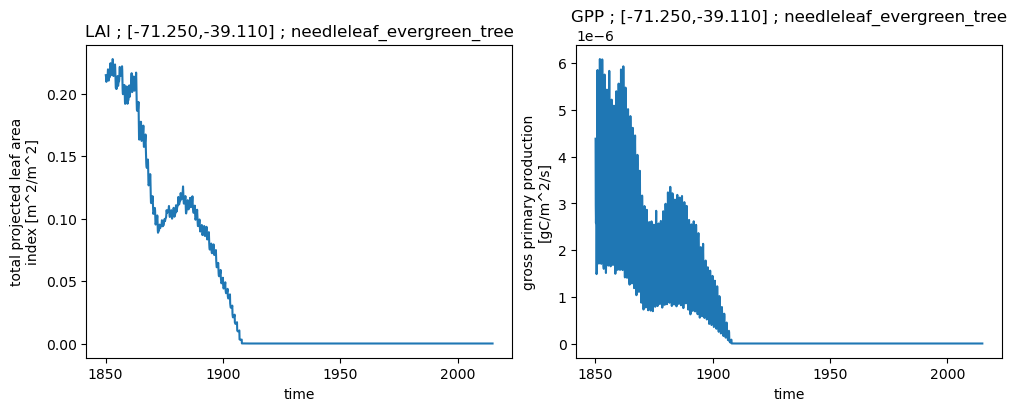

In [5]:
fig, ax = plt.subplots(
    1, 2,
    figsize=(10,4),
    layout='constrained'
)

lon = -71.25
lat = -39.109947

lai.isel(vegtype=1).sel(time=slice('1850', '2014'), lon=lon, lat=lat).plot(ax=ax[0])
gpp.isel(vegtype=1).sel(time=slice('1850', '2014'), lon=lon, lat=lat).plot(ax=ax[1])

ax[0].set_title(f'LAI ; [{lon: 0.3f},{lat: 0.3f}] ; needleleaf_evergreen_tree')
ax[1].set_title(f'GPP ; [{lon: 0.3f},{lat: 0.3f}] ; needleleaf_evergreen_tree')

85


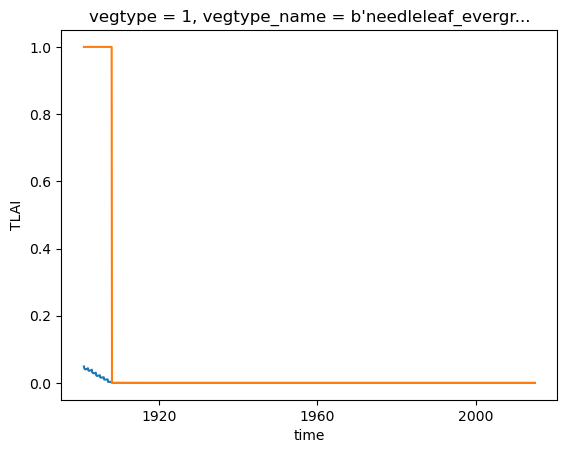

In [14]:
this_lai = lai.isel(vegtype=1).sel(time=slice('1901', '2014'), lon=lon, lat=lat)
this_lai.plot()
xr.where(this_lai>1e-3, 1, 0).plot()
print(xr.where(this_lai>1e-3, 1, 0).sum().values)

In [44]:
def get_alive_time_indices(lai, alive_lai_threshold=1e-3):
    alive_time_indices = []

    counter = -1
    is_new_sequence = True

    for i, v in enumerate(lai.values):
        if v > alive_lai_threshold:
            if is_new_sequence:
                alive_time_indices.append([])
                counter += 1
            alive_time_indices[counter].append(i)
            is_new_sequence = False
        else:
            is_new_sequence = True
    
    return alive_time_indices

In [59]:
these_indices = get_alive_time_indices(this_lai, alive_lai_threshold=1e-3)

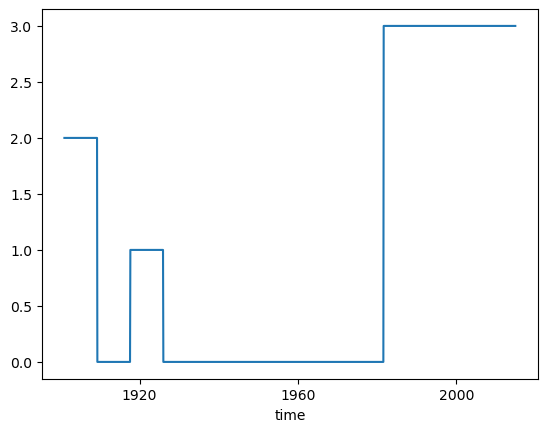

In [50]:
test_time = lai.sel(time=slice('1901', '2014')).time
test_data = np.zeros(test_time.size)

test_data[0:100] = 2
test_data[200:300] = 1
test_data[-400:] = 3

test_da = xr.DataArray(
    data=test_data,
    dims=['time'],
    coords={'time': test_time}
)

test_da.plot()

alive_lai_threshold = 1e-3
alive_time_indices = []

counter = -1
is_new_sequence = True

for i, v in enumerate(test_da.values):
    if v > alive_lai_threshold:
        if is_new_sequence:
            alive_time_indices.append([])
            counter += 1
        alive_time_indices[counter].append(i)
        is_new_sequence = False
    else:
        is_new_sequence = True
    

# Load data

In [4]:
# sites_with_angtreepfts = xr.open_dataset('/glade/work/bbuchovecky/WUE_analysis/sites_from_gridded/sites_with_angtreepfts.nc')['sites_with_angtreepfts']
# sites_with_gymtreepfts = xr.open_dataset('/glade/work/bbuchovecky/WUE_analysis/sites_from_gridded/sites_with_gymtreepfts.nc')['sites_with_gymtreepfts']

time_period_month = slice('1965-01', '2014-12')
time_period_year = slice('1965', '2014')

da_pft_mon = xr.open_dataset('/glade/work/bbuchovecky/WUE_analysis/sites_from_gridded/clm50_cesm23a02cPPEn08ctsm51d030_1deg_GSWP3V1_hist.clm2.h1.GPP.185001-201412_sites.nc')
da_pft_mon = da_pft_mon.sel(time=time_period_month)
da_pft_mon = da_pft_mon['GPP']

da_pft_ann = calculate_annual_timeseries(da_pft_mon)

pft_subset = da_pft_mon['pft'][1:4]
pft_subset_slice = slice(1, 3)

# Testing monthly vs. annual trends

In [17]:
monthly_trend = stats.linregress(
    np.arange(da_pft_mon['time'].size),
    da_pft_mon.isel(pft=1, site=23)
)

annual_trend = stats.linregress(
    np.arange(da_pft_ann['year'].size),
    da_pft_ann.isel(pft=1, site=23)
)

In [21]:
monthly_trend.slope * 12

2.3538107557545805e-07

In [22]:
annual_trend.slope

2.3670978938734466e-07

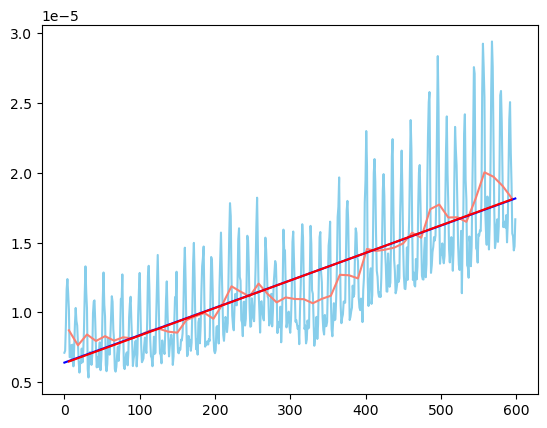

In [20]:
plt.plot(np.arange(da_pft_mon['time'].size), da_pft_mon.isel(pft=1, site=23), c='skyblue')
plt.plot(np.arange(da_pft_ann['year'].size)*12+6, da_pft_ann.isel(pft=1, site=23), c='salmon')

plt.plot(
    np.arange(da_pft_mon['time'].size),
    np.arange(da_pft_mon['time'].size)*monthly_trend.slope + monthly_trend.intercept,
    c='blue'
)

plt.plot(
    np.arange(da_pft_ann['year'].size)*12+6,
    (np.arange(da_pft_ann['year'].size))*annual_trend.slope + annual_trend.intercept,
    c='red'
)

# for i in range(da_pft_ann['year'].size):
#     plt.axvline(i*12, 0, 200000, c='lightgray', lw=0.75, zorder=0)

# plt.ylim(60000, 80000)

# Method 1: trend, then PFT
1. Compute the trend of C per month for each PFT
2. Average over the PFT dimemsion
3. Convert the trend from per month to per decade

In [ ]:
# da1_pft_mon_trend
# da1_pft_dec_trend
# da1_dec_trend

In [48]:
nsite = da_pft_mon['site'].size
npft = pft_subset.size
nstats = 3

site_linregress = np.zeros((nsite, npft, nstats))
site_pft_mask = np.zeros((nsite, npft))

for i, this_site in enumerate(da_pft_mon):
    # Create a time array for the linear regression
    month = np.arange(0, len(this_site['time']), 1)

    # Iterate through the specified PFTs
    for j, this_pft in enumerate(pft_subset):
        # Check if the PFT exists for the given site
        if ~np.isnan(this_site.sel(pft=j).isel(time=0)):
            # Update the site-level PFT mask to indicate that the PFT exists
            site_pft_mask[i,j] = 1

            # Perform the linear regression
            lr = stats.linregress(
                month,
                this_site.sel(pft=j)
            )

            # Save the linear regression statistics
            site_linregress[i,j,0] = lr.slope * 12 * 10  # Convert slope from X/1month to X/10yr
            site_linregress[i,j,1] = lr.rvalue
            site_linregress[i,j,2] = lr.pvalue

        # Fill with NaN if the PFT does not exist for the given site
        else:
            site_linregress[i,j,:] = [np.nan, np.nan, np.nan]

da1_pft_dec_trend = xr.DataArray(
    data=site_linregress,
    dims=['site', 'pft', 'stats'],
    coords=dict(
        site=np.arange(nsite),
        pft=pft_subset,
        stats=np.arange(3),
        stats_descr=(('stats'), np.array(['slope', 'rvalue', 'pvalue'])),
    ),
)

In [33]:
da1_dec_trend = da1_pft_dec_trend.isel(site=sites_with_gymtreepfts).sel(pft=pft_subset_slice, stats=0).mean(dim='pft', skipna=True)

# Method 2: PFT, then trend
1. Average over the PFT dimension
2. Compute the trend of X per month
3. Convert the trend from per month to per decade
<!-- 
1. Average over the relevant PFTs (angiosperm vs. gymnosperm)
2. Average over the months to create an annual timeseries
3. Compute the trend per year
4. Convert the trend from per year to per decade -->

In [23]:
def calculate_annual_timeseries(da):
    """
    Calculates the annual timeseries, weighted by the number of days in each month
    """
    nyears = len(da.groupby('time.year'))
    month_length = da.time.dt.days_in_month

    weights = month_length.groupby('time.year') / month_length.astype(float).groupby('time.year').sum()        
    np.testing.assert_allclose(weights.groupby('time.year').sum().values, np.ones(nyears)) 

    return (da * weights).groupby('time.year').sum(dim='time')

In [24]:
main_directory = '/glade/work/bbuchovecky/WUE_analysis'
case_name = 'clm50_cesm23a02cPPEn08ctsm51d030_1deg_GSWP3V1_hist'
var = 'GSSUNLN'

this_site_data = xr.open_dataset(f'{main_directory}/sites_from_gridded/{case_name}.clm2.h1.{var}.185001-201412_sites.nc')
this_site_data = this_site_data.sel(time=time_period_month)
this_site_data = this_site_data[var]

In [26]:
da2_mon = this_site_data.isel(site=sites_with_gymtreepfts).sel(pft=pft_subset_slice).mean(dim='pft')
da2_ann = calculate_annual_timeseries(da2_mon)
da2_ann['year'] = np.arange(len(da2_ann['year']))

In [27]:
da2_ann_trend = da2_ann.polyfit(dim='year', deg=1, full=True)
da2_ann_trend = da2_ann_trend['polyfit_coefficients'].sel(degree=1)
da2_dec_trend = da2_ann_trend * 10

# Compare

In [41]:
da1_dec_trend

<xarray.DataArray (site: 265)>
array([ 7.09435327e+04,  3.04749366e+04, -2.14979921e+04, -2.14979921e+04,
       -3.30052032e+04, -3.30052032e+04,  1.69250648e+03, -2.46823451e+04,
       -2.46823451e+04, -2.46823451e+04, -2.46823451e+04, -2.17277684e+04,
       -2.17277684e+04,  4.53525886e+04, -1.89311472e+04, -1.89311472e+04,
       -9.91370283e+02, -3.05294640e+04, -9.66598037e+03, -4.07653476e+04,
       -2.38635254e+04, -2.83354683e+04, -3.80362006e+03, -2.83354683e+04,
       -3.85218066e+04, -1.14668388e+04, -1.26848107e+04,  6.86514704e+03,
        1.70364675e+03, -1.50017964e+04,  1.77093688e+03, -7.69410872e+03,
       -7.69410872e+03, -7.69410872e+03, -4.07490129e+04,  9.22270245e+03,
       -1.99343453e+04,  8.42494343e+03,  2.19713054e+04, -1.99343453e+04,
        4.36120824e+03,  1.05429486e+04, -1.56952588e+04, -1.11740054e+04,
        5.87498002e+03,  5.87498002e+03,  5.87498002e+03, -7.90715780e+03,
       -7.47305066e+03, -7.47305066e+03,  3.29986563e+04, -7.47305066e+03,
       -1.35521181e+04, -1.08914916e+04, -1.17255656e+04, -3.97431690e+03,
       -6.30955859e+03, -1.13067087e+04, -3.97431690e+03, -3.97431690e+03,
       -3.97431690e+03, -3.97431690e+03, -3.97431690e+03,  1.03964996e+04,
       -2.32120326e+03, -3.02301553e+03,  7.11966513e+03, -1.55954166e+03,
       -1.55954166e+03, -1.55954166e+03, -1.55954166e+03, -1.87839698e+04,
       -1.55954166e+03, -1.21518124e+04, -1.21518124e+04, -1.21518124e+04,
        7.11966513e+03, -9.01591464e+03, -9.87148212e+02, -9.01591464e+03,
...
        8.35418361e+03,  4.24400521e+04,  1.15392215e+04,  1.15392215e+04,
        2.83270102e+04,  8.10104702e+03,  3.88943121e+04,  2.33290253e+04,
        8.70062574e+03,  1.04544570e+04, -6.46874096e+02,  1.48164033e+04,
        1.15083635e+04,  1.15083635e+04,  1.15083635e+04,  1.46007535e+04,
        1.04348812e+04,  1.16198098e+04,  1.16198098e+04,  2.88622163e+04,
        2.88622163e+04,  1.08022247e+04,  1.08022247e+04, -3.26376360e+04,
        9.09085916e+03,  5.45462396e+04,  2.43240562e+02,  3.80772400e+03,
       -2.39319726e+04, -5.87841042e+04, -1.95154607e+04,  4.92324433e+04,
       -1.47861397e+04, -7.24948122e+03, -1.40648994e+04,  4.54366770e+04,
       -6.86210485e+03, -1.87533666e+04, -1.99343453e+04, -1.07949521e+04,
       -1.99343453e+04,  3.52476589e+03,  3.53009582e+01, -1.88974666e+04,
       -1.62738086e+04, -1.68493302e+04, -1.24241540e+04,  3.04849426e+04,
       -8.08172267e+03,  3.04849426e+04, -7.90715780e+03, -1.24241540e+04,
       -8.08172267e+03, -1.76441612e+04, -1.24241540e+04, -1.24241540e+04,
        5.31422654e+04,  5.31422654e+04, -1.05973222e+04,  2.48556845e+04,
       -2.59913554e+03, -1.55954166e+03,  7.11966513e+03, -9.01591464e+03,
       -9.87148212e+02, -4.74278488e+03, -1.80456097e+04,  2.39499432e+04,
        2.39499432e+04, -4.05879570e+03,  1.16547714e+04,  1.16547714e+04,
        1.16547714e+04,  1.82081603e+03, -7.61141684e+03, -7.86468366e+02,
        3.44566410e+03])
Coordinates:
  * site         (site) int64 0 1 22 23 24 25 26 ... 423 424 425 426 429 430 431
    stats        int64 0
    stats_descr  <U6 'slope'

In [45]:
da2_dec_trend

<xarray.DataArray 'polyfit_coefficients' (site: 265)>
array([ 45212.17287564,   5018.66269531,   3892.31439426,   3892.31439426,
        -3691.38493151,  -3691.38493151,   6299.42978382,  -5335.05292166,
        -5335.05292166,  -5335.05292166,  -5335.05292166,  -3983.63306667,
        -3983.63306667,  23826.14384164, -14233.49127783, -14233.49127783,
        11721.85911815, -24325.47102954,  -9338.39077617, -33096.77020548,
       -15008.97060146,   1115.22660832,  -7165.84255137,   1115.22660832,
         -635.05220061,   2501.478226  ,   5121.027218  ,  23563.1474897 ,
         7089.86850385,   2460.54592787,  15206.07170109,   9783.73623582,
         9783.73623582,   9783.73623582, -20124.92402344,  22950.11237693,
         2375.00824025,  25227.67904671,  17753.48566995,   2375.00824025,
         7052.99785959,   5994.00203339, -14375.34634525,   8738.91805169,
        23288.92340539,  23288.92340539,  23288.92340539,  14100.58179714,
        14821.44661414,  14821.44661414,  24917.02128639,  14821.44661414,
        13301.30115816,  -9192.27105897,   2895.31778681,  14764.24042567,
         8856.40878906,   5408.32258669,  14764.24042567,  14764.24042567,
        14764.24042567,  14764.24042567,  14764.24042567,  26303.78714148,
        11158.27183219,  10461.78334493,  20983.67678457,  12241.87730629,
        12241.87730629,  12241.87730629,  12241.87730629,  -1774.81129201,
        12241.87730629,    693.94641481,    693.94641481,    693.94641481,
        20983.67678457,     99.15984589,   5667.81936002,     99.15984589,
...
       -16156.72475787,  14183.02983332, -10502.85230496, -10502.85230496,
         6617.25119951, -10090.78464719,  16518.86231388,  -4195.57198403,
       -10751.26555744, -23472.99495933, -21733.55733358,  -3997.36112479,
       -29262.21011879, -29262.21011879, -29262.21011879,  -8207.45220914,
         6700.77063356,   9591.28819563,   9591.28819563,  14731.17489298,
        14731.17489298,   2782.77080479,   2782.77080479, -31502.28865582,
        14375.8479345 ,  45341.96543236,   -330.10214041,   7456.93761772,
       -14660.59754923, -45472.81684035,  -3501.13171821,  31932.74774688,
        -6160.79882277,  10690.11168731,  10966.84601014,  19598.59731771,
        11822.29159889,   2655.46034354,   2375.00824025,   9952.05190764,
         2375.00824025,   4477.29226241,  20548.6218255 ,   5766.71466315,
         4587.66279431,   4634.67160745,   6162.52197935,  17287.77217198,
        15717.16250736,  17287.77217198,  14100.58179714,   6162.52197935,
        15717.16250736,   8823.28962436,   6162.52197935,   6162.52197935,
        23167.5543406 ,  23167.5543406 ,  10738.5297089 ,  22007.73408069,
        11243.88196169,  12241.87730629,  20983.67678457,     99.15984589,
         5667.81936002,  -1538.97001284,  -4249.72847549,   7955.1966633 ,
         7955.1966633 ,  -8322.64530982,  10186.61271939,  10186.61271939,
        10186.61271939,  -1277.92534247,    866.38630672,  -8253.50379923,
       -14547.01129334])
Coordinates:
    degree   int64 1
  * site     (site) int64 0 1 22 23 24 25 26 27 ... 423 424 425 426 429 430 431

(array([ 5., 11., 31., 32., 41., 34., 43., 48., 19.,  1.]),
 array([-40770.57359663, -32904.84080166, -25039.10800669, -17173.37521173,
         -9307.64241676,  -1441.90962179,   6423.82317318,  14289.55596815,
         22155.28876311,  30021.02155808,  37886.75435305]),
 <BarContainer object of 10 artists>)

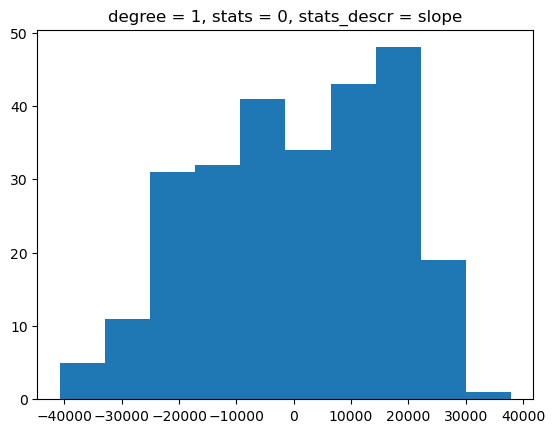

In [44]:
(da2_dec_trend - da1_dec_trend).plot.hist()

(array([ 1.,  5.,  8., 35., 75., 63., 58., 17.,  1.,  2.]),
 array([-45472.81684035, -36391.33861308, -27309.86038581, -18228.38215854,
         -9146.90393127,    -65.42570399,   9016.05252328,  18097.53075055,
         27179.00897782,  36260.48720509,  45341.96543236]),
 <BarContainer object of 10 artists>)

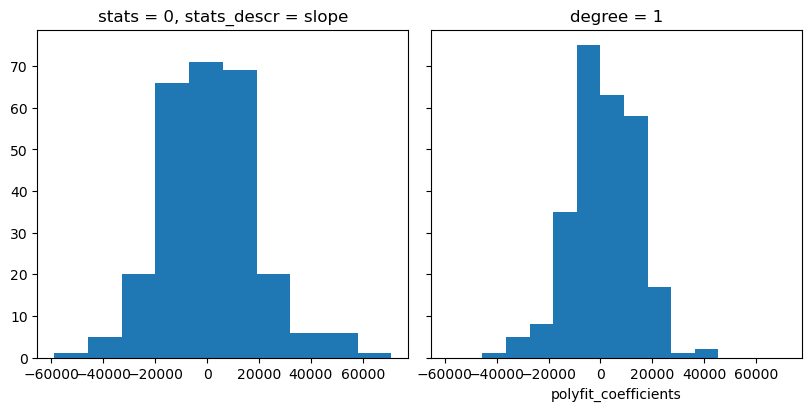

In [38]:
fig, axes = plt.subplots(
    1, 2, figsize=(8,4),
    layout='constrained',
    sharey=True, sharex=True,
)
ax = axes.ravel()

da1_dec_trend.plot.hist(ax=ax[0])
da2_dec_trend.plot.hist(ax=ax[1])

In [39]:
stats.ttest_1samp(da1_dec_trend, 0)

TtestResult(statistic=0.8621572398157941, pvalue=0.3893834551708164, df=264)

In [40]:
stats.ttest_1samp(da2_dec_trend, 0)

TtestResult(statistic=1.7848076487597428, pvalue=0.0754406707199674, df=264)

# TESTING

In [64]:
import statsmodels.api as sm
import scipy.stats as stats

In [170]:
var = 'TLAI'

da = xr.open_dataset(f'/glade/work/bbuchovecky/WUE_analysis/timeseries_from_gridded/clm50_cesm23a02cPPEn08ctsm51d030_1deg_GSWP3V1_hist.clm2.h1.{var}.185001-201412_gridded_annts.nc')
da = da[var].sel(year=slice(1901,2014))

latlon = da.sel(pft=1, lat=43, lon=-122, method='nearest')
latlon['year'] = np.arange(latlon.year.size)

x = latlon.year.values
y = latlon.values

In [171]:
%%time

latlon = da.sel(pft=1, lat=43, lon=-122, method='nearest')

x = np.arange(latlon.year.size)
y = latlon.values

x_with_intercept = sm.add_constant(x)

model = sm.OLS(y, x_with_intercept)
sm_results = model.fit()
sm_yhat = results.predict(x_with_intercept)

sm_intercept, sm_slope = results.params

print(f'y ={sm_slope: 0.5f}x +{sm_intercept: 0.5f}')

y = 0.01130x + 5.11264
CPU times: user 3.86 ms, sys: 2.72 ms, total: 6.59 ms
Wall time: 5.54 ms


In [172]:
%%time

latlon = da.sel(pft=1, lat=43, lon=-122, method='nearest')

x = np.arange(latlon.year.size)
y = latlon.values

sp_results = stats.linregress(x, y)

print(f'y ={sp_results.slope: 0.5f}x +{sp_results.intercept: 0.5f}')

y = 0.01130x + 5.11264
CPU times: user 6.14 ms, sys: 0 ns, total: 6.14 ms
Wall time: 5.49 ms


In [173]:
%%time

xr_results = latlon.polyfit(dim='year', deg=1, full=True)

print(f'y ={xr_results.polyfit_coefficients.sel(degree=1): 0.5f}x +{xr_results.polyfit_coefficients.sel(degree=0): 0.5f}')

y = 0.01130x +-16.36408
CPU times: user 3.92 ms, sys: 0 ns, total: 3.92 ms
Wall time: 3.88 ms


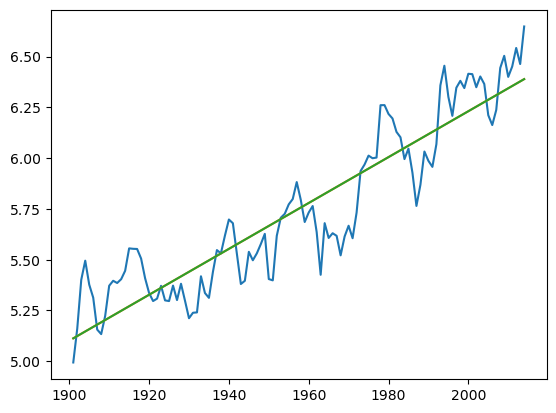

In [181]:
plt.plot(x+1901, y)
plt.plot(x+1901, yhat)
plt.plot(x+1901, sp_results.slope * x + sp_results.intercept)
# plt.plot(latlon.year, xr_results.polyfit_coefficients.sel(degree=1).item() * latlon.year + xr_results.polyfit_coefficients.sel(degree=0).item())

In [182]:
%%time

var = 'TLAI'

da = xr.open_dataset(f'/glade/work/bbuchovecky/WUE_analysis/timeseries_from_gridded/clm50_cesm23a02cPPEn08ctsm51d030_1deg_GSWP3V1_hist.clm2.h1.{var}.185001-201412_gridded_annts.nc')
da = da[var].sel(year=slice(1901,2014))

da = da.sel(pft=1, lat=43, lon=-122, method='nearest')

xr_results = da.polyfit(dim='year', deg=1)

CPU times: user 11 ms, sys: 11.6 ms, total: 22.7 ms
Wall time: 363 ms


In [183]:
%%time
xr_predict = xr.polyval(da.year, xr_results)

CPU times: user 7.57 ms, sys: 0 ns, total: 7.57 ms
Wall time: 6.99 ms


In [201]:
xr_predict['polyfit_coefficients'].attrs = {'test': 'test'}

In [204]:
xr_predict['polyfit_coefficients'].attrs['ok'] = 'ok'

In [205]:
xr_predict

<xarray.Dataset>
Dimensions:               (year: 114)
Coordinates:
    pft                   int64 1
    pft_name              |S40 b'needleleaf_evergreen_temperate_tree     '
    lat                   float32 42.88
    lon                   float32 0.0
  * year                  (year) int64 1901 1902 1903 1904 ... 2012 2013 2014
Data variables:
    polyfit_coefficients  (year) float64 5.113 5.124 5.135 ... 6.367 6.378 6.389
Attributes:
    test:     test

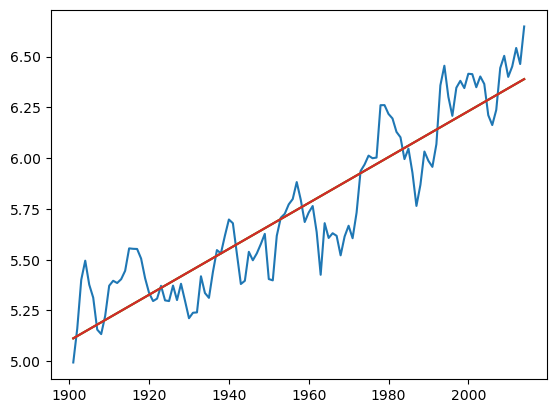

In [188]:
plt.plot(da.year, da.values)

plt.plot(x+1901, yhat)
plt.plot(x+1901, sp_results.slope * x + sp_results.intercept)

plt.plot(da.year, xr_predict.polyfit_coefficients)

In [166]:
xr_predict.polyfit_coefficients

<xarray.DataArray 'polyfit_coefficients' (year: 114)>
array([5.11264091, 5.1239385 , 5.13523609, 5.14653368, 5.15783128,
       5.16912887, 5.18042646, 5.19172405, 5.20302164, 5.21431923,
       5.22561682, 5.23691441, 5.248212  , 5.25950959, 5.27080718,
       5.28210477, 5.29340237, 5.30469996, 5.31599755, 5.32729514,
       5.33859273, 5.34989032, 5.36118791, 5.3724855 , 5.38378309,
       5.39508068, 5.40637827, 5.41767586, 5.42897346, 5.44027105,
       5.45156864, 5.46286623, 5.47416382, 5.48546141, 5.496759  ,
       5.50805659, 5.51935418, 5.53065177, 5.54194936, 5.55324695,
       5.56454455, 5.57584214, 5.58713973, 5.59843732, 5.60973491,
       5.6210325 , 5.63233009, 5.64362768, 5.65492527, 5.66622286,
       5.67752045, 5.68881805, 5.70011564, 5.71141323, 5.72271082,
       5.73400841, 5.745306  , 5.75660359, 5.76790118, 5.77919877,
       5.79049636, 5.80179395, 5.81309154, 5.82438914, 5.83568673,
       5.84698432, 5.85828191, 5.8695795 , 5.88087709, 5.89217468,
       5.90347227, 5.91476986, 5.92606745, 5.93736504, 5.94866263,
       5.95996023, 5.97125782, 5.98255541, 5.993853  , 6.00515059,
       6.01644818, 6.02774577, 6.03904336, 6.05034095, 6.06163854,
       6.07293613, 6.08423372, 6.09553132, 6.10682891, 6.1181265 ,
       6.12942409, 6.14072168, 6.15201927, 6.16331686, 6.17461445,
       6.18591204, 6.19720963, 6.20850722, 6.21980482, 6.23110241,
       6.2424    , 6.25369759, 6.26499518, 6.27629277, 6.28759036,
       6.29888795, 6.31018554, 6.32148313, 6.33278072, 6.34407831,
       6.35537591, 6.3666735 , 6.37797109, 6.38926868])
Coordinates:
    pft       int64 1
    pft_name  |S40 b'needleleaf_evergreen_temperate_tree     '
    lat       float32 42.88
    lon       float32 0.0
  * year      (year) int64 1901 1902 1903 1904 1905 ... 2010 2011 2012 2013 2014

In [206]:
time_period_in_years = [
    [1901, 2014],
    [1901, 1964],
    [1965, 2014],
]

for start, end in time_period_in_years:
    print(f'{start}-{end}')

1901-2014
1901-1964
1965-2014
